In [ ]:
# default_exp model.__init__

# Deep Learning Model

In [ ]:
# export 
import os 
import os.path as path
from typing import Tuple

import dateutil.parser as parser
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import airathon.data.tfrecord as tfrecord
import airathon.paths as paths
from airathon.metrics import R2

In [ ]:
tf.__version__

'2.7.0'

In [ ]:
# export
Dataset = tf.data.Dataset

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display

## Loading Data

In [ ]:
ds = tfrecord.load_tfrecord(
    path.join(paths.dataset(), "train", "maiac", "maiac-2000.tfrecord"))

ds.element_spec

{'datetime': TensorSpec(shape=(), dtype=tf.string, name=None),
 'grid_id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'location': TensorSpec(shape=(), dtype=tf.string, name=None),
 'sds_0': TensorSpec(shape=(240, 240, 4), dtype=tf.float32, name=None),
 'sds_3': TensorSpec(shape=(240, 240, 4), dtype=tf.float32, name=None),
 'sds_4': TensorSpec(shape=(240, 240, 4), dtype=tf.float32, name=None),
 'sds_8': TensorSpec(shape=(240, 240, 4), dtype=tf.float32, name=None),
 'value': TensorSpec(shape=(), dtype=tf.float32, name=None)}

## Preprocessing

In [ ]:
# export 
@tf.function
def _get_y(x):
    return tf.reshape(x["value"], (1,))

def get_y(dataset: Dataset) -> Dataset:
    return dataset.map(_get_y, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
ds_y = get_y(ds)
print(ds_y.element_spec)

for y in ds_y.take(1):
    print(y)

TensorSpec(shape=(1,), dtype=tf.float32, name=None)
tf.Tensor([10.125], shape=(1,), dtype=float32)


In [ ]:
# export
@tf.function 
def location_to_one_hot(location: tf.Tensor):
    if location == "tpe":
        return tf.constant([1, 0, 0], dtype=tf.float32)
    if location == "la":
        return tf.constant([0, 1, 0], dtype=tf.float32)

    return tf.constant([0, 0, 1], dtype=tf.float32)

In [ ]:
location_to_one_hot(tf.constant(["tpe"]))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 0., 0.], dtype=float32)>

In [ ]:
# export
@tf.function
def _get_x(x):
    sds_0 = tf.reshape(x["sds_0"], (-1,))
    sds_3 = tf.reshape(x["sds_3"], (-1,))
    sds_4 = tf.reshape(x["sds_4"], (-1,))
    sds_8 = tf.reshape(x["sds_8"], (-1,))

    location = location_to_one_hot(x["location"])

    output = tf.concat([sds_0, sds_3, sds_4, sds_8, location], axis=0)

    return output

def get_x(x: Dataset) -> Dataset:
    return x.map(_get_x, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
ds_x = get_x(ds)
print(ds_x.element_spec)

for x in ds_x.take(1):
    print(x.shape)

TensorSpec(shape=(921603,), dtype=tf.float32, name=None)
(921603,)


In [ ]:
ds_x_y = Dataset.zip((ds_x, ds_y))
ds_x_y = ds_x_y.shuffle(2000)
ds_x_y.element_spec

(TensorSpec(shape=(921603,), dtype=tf.float32, name=None),
 TensorSpec(shape=(1,), dtype=tf.float32, name=None))

In [ ]:
total_size = 2000
train_size = int(np.floor(2000 * 0.8))
val_size = int(total_size - train_size)

print(f"total_size = {total_size}")
print(f"train_size = {train_size}")
print(f"val_size = {val_size}")

ds_train = ds_x_y.take(train_size)
ds_val = ds_x_y.skip(train_size)

total_size = 2000
train_size = 1600
val_size = 400


## Defining Model

In [ ]:
# export 
class ImageModel(keras.models.Model):
    def __init__(self) -> None:
        super().__init__()
        self._input = keras.layers.InputLayer((240, 240, 4))

        self.conv2d1 = keras.layers.Conv2D(
            filters=16,
            kernel_size=(3, 3),
            activation="relu")

        self.maxpool1 = keras.layers.MaxPool2D()
        self.dropout1 = keras.layers.Dropout(0.25)

        self.conv2d2 = keras.layers.Conv2D(
            filters=16,
            kernel_size=(3, 3),
            activation="relu")

        self.maxpool2 = keras.layers.MaxPool2D()
        self.dropout2 = keras.layers.Dropout(0.25) 
        self.flatten = keras.layers.Flatten()

    def call(self, image):
        image = self._input(image)
        image = self.conv2d1(image)
        image = self.maxpool1(image)
        image = self.dropout1(image)
        image = self.conv2d2(image)
        image = self.maxpool2(image)
        image = self.dropout2(image)

        image = self.flatten(image)

        return image


class MyModel(keras.models.Model):
    def __init__(self) -> None:
        super().__init__()

        self.call_count = 0

        self._input = keras.layers.InputLayer((240 * 240 * 4 * 4 + 3,))

        self.image1 = ImageModel()
        self.image2 = ImageModel()
        self.image3 = ImageModel()
        # self.image4 = ImageModel()

        self.dense1 = keras.layers.Dense(64, activation="relu")
        self.dropout3 = keras.layers.Dropout(0.2)
        self.dense2 = keras.layers.Dense(32, activation="relu")
        self.dropout4 = keras.layers.Dropout(0.2)
        self.dense3 = keras.layers.Dense(16, activation="relu")
        self.dense4 = keras.layers.Dense(1)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        x = self._input(x)

        image_size = 240 * 240 * 4
        location_size = 3

        image1 = x[:, 0:image_size]
        image1 = tf.reshape(image1, (-1, 240, 240, 4))

        image2 = x[:, image_size:image_size * 2]
        image2 = tf.reshape(image2, (-1, 240, 240, 4))

        image3 = x[:, image_size * 2:image_size * 3]
        image3 = tf.reshape(image3, (-1, 240, 240, 4))

        # image4 = x[:, image_size * 3:image_size * 4]
        # image4 = tf.reshape(image4, (-1, 240, 240, 4))

        location = x[:, image_size * 4:]
        location = tf.reshape(location, (-1, 3))

        image1 = self.image1(image1)
        image2 = self.image2(image2)
        image3 = self.image3(image3)
        # image4 = self.image4(image4)

        x = tf.concat([image1, image2, image3, location], axis=1)

        x = self.dense1(x)
        x = self.dropout3(x)
        x = self.dense2(x)
        x = self.dropout4(x)
        x = self.dense3(x)
        x = self.dense4(x)

        return x


def create_compiled_model() -> keras.Model:
    model = MyModel()

    model.compile(
        loss="MSE",
        optimizer="adam",
        metrics=[R2(), keras.metrics.RootMeanSquaredError()])

    return model

## Training

In [ ]:
model = create_compiled_model()

Epoch 1/40
16/16 [==============================] - 15s 647ms/step - loss: 6232.3823 - R2: 0.0584 - root_mean_squared_error: 78.9454
Epoch 2/40
16/16 [==============================] - 14s 642ms/step - loss: 6256.1802 - R2: -0.0545 - root_mean_squared_error: 79.0960
Epoch 3/40
16/16 [==============================] - 14s 643ms/step - loss: 6409.5767 - R2: -0.0420 - root_mean_squared_error: 80.0598
Epoch 4/40
16/16 [==============================] - 14s 642ms/step - loss: 6008.9150 - R2: 0.1416 - root_mean_squared_error: 77.5172
Epoch 5/40
16/16 [==============================] - 15s 643ms/step - loss: 5986.1489 - R2: 0.0928 - root_mean_squared_error: 77.3702
Epoch 6/40
16/16 [==============================] - 14s 642ms/step - loss: 5928.6768 - R2: 0.2083 - root_mean_squared_error: 76.9979
Epoch 7/40
16/16 [==============================] - 14s 643ms/step - loss: 6033.9102 - R2: 0.0106 - root_mean_squared_error: 77.6782
Epoch 8/40
16/16 [==============================] - 14s 644ms/step 

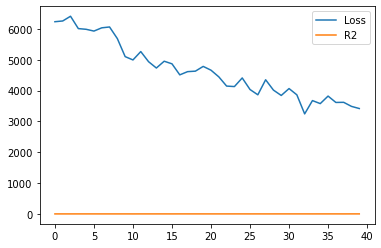

In [ ]:
# tensorboard = keras.callbacks.TensorBoard(log_dir="logs")
history = model.fit(
    ds_train.batch(100), 
    epochs=40, 
    # validation_data=ds_val.batch(100)
)

plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["R2"], label="R2")
# plt.plot(history.history["val_R2"], label="Val R2")

plt.legend()

model.summary()

## Saving Model

In [ ]:
model_path = path.join("saves", "zc2616_v1")
model.save_weights(model_path)

In [ ]:
test_ds = tfrecord.load_tfrecord(
    path.join(paths.dataset(), "test", "maiac", "maiac.tfrecord"))

test_ds = test_ds.take(1000)
test_x = get_x(test_ds)
test_x.element_spec

TensorSpec(shape=(921603,), dtype=tf.float32, name=None)

In [ ]:
test_datetime = list()
test_grid_id = list()

for row in test_ds:
    
    datetime = row["datetime"].numpy().decode("UTF-8")
    grid_id = row["grid_id"].numpy().decode("UTF-8")

    print(grid_id)

    test_datetime.append(datetime)
    test_grid_id.append(grid_id)

1X116
9Q6TA
KW43U
VR4WG
XJF9O
3S31A
A2FBI
DJN0F
E5P9N
FRITQ
H96P6
PG3MI
QJHW4
WT52R
X5DKW
ZP1FZ
ZZ8JF
1X116
9Q6TA
KW43U
VR4WG
XJF9O
3S31A
A2FBI
DJN0F
E5P9N
FRITQ
H96P6
PG3MI
QJHW4
WT52R
X5DKW
ZP1FZ
ZZ8JF
1X116
9Q6TA
KW43U
VR4WG
XJF9O
3S31A
A2FBI
DJN0F
E5P9N
FRITQ
H96P6
PG3MI
QJHW4
WT52R
X5DKW
ZP1FZ
ZZ8JF
1X116
9Q6TA
KW43U
VR4WG
XJF9O
1X116
9Q6TA
KW43U
VR4WG
XJF9O
3S31A
A2FBI
E5P9N
FRITQ
H96P6
PG3MI
QJHW4
WT52R
X5DKW
ZP1FZ
ZZ8JF
1X116
9Q6TA
KW43U
VR4WG
XJF9O
3S31A
A2FBI
DJN0F
E5P9N
FRITQ
H96P6
PG3MI
WT52R
X5DKW
ZP1FZ
ZZ8JF
1X116
9Q6TA
KW43U
VR4WG
XJF9O
3S31A
A2FBI
DJN0F
E5P9N
FRITQ
H96P6
PG3MI
QJHW4
WT52R
X5DKW
ZP1FZ
ZZ8JF
1X116
9Q6TA
KW43U
VR4WG
XJF9O
3S31A
A2FBI
DJN0F
E5P9N
FRITQ
H96P6
PG3MI
QJHW4
WT52R
X5DKW
ZP1FZ
ZZ8JF
1X116
9Q6TA
KW43U
VR4WG
XJF9O
3S31A
A2FBI
DJN0F
E5P9N
FRITQ
H96P6
PG3MI
QJHW4
WT52R
X5DKW
ZP1FZ
ZZ8JF
1X116
9Q6TA
KW43U
VR4WG
XJF9O
3S31A
A2FBI
DJN0F
E5P9N
FRITQ
H96P6
PG3MI
QJHW4
WT52R
X5DKW
ZP1FZ
1X116
9Q6TA
KW43U
VR4WG
XJF9O
3S31A
A2FBI
DJN0F
E5P9N
FRITQ
H96P6
PG3M

In [ ]:
predict_result = model.predict(test_x.batch(100))

In [ ]:
test_value = list() 

for y in predict_result: 
    test_value.append(y[0])

In [ ]:
import pandas as pd

In [ ]:
test_df = pd.DataFrame({
    "datetime": test_datetime, "grid_id": test_grid_id, "value": test_value})

test_df

NameError: name 'pd' is not defined

In [ ]:
test_df.to_csv("result.csv", index=False)